[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saulventura/CS-7641-Assignment1/blob/master/HRAnalytics.ipynb)
  
    

# Project:

The present project aims to predict if an employee will leave the current company (or will resign from the current company).
 
To understand the factors that lead an employee to leave the company, it is required to design a model that uses the current credentials/demographics/experience to predict if an employee is planning to leave the company.

This information is crucial, since managing correctly the Employee Attrition potential values, HR can implement some actions to retain those employees, or eventually hiring the new alternative of them.

# Employee Attrition
<img src="HRAnalytics.jpg" width="100%" height="100%"/>

In [172]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from IPython.display import Markdown, display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b><h1>1. Data Collection</h1></div>
</a><a class="anchor" id="exploration"></a>

In [173]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [174]:
train_orig = pd.read_csv('HRdataset.csv')

In [175]:
train_orig.head()

,table id,name,phone number,Location,Emp. Group,Function,Gender,Tenure,Tenure Grp.,Experience (YY.MM),Marital Status,Age in YY.,Hiring Source,Promoted/Non Promoted,Job Role Match,Stay/Left
0,1,sid,9876544345,Pune,B2,Operation,Male,0.00,< =1,6.08,Single,27.12,Direct,Non Promoted,Yes,Left
1,2,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay
2,3,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay
3,4,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay
4,5,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay


In [176]:
train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   table id               902 non-null    int64  
 1   name                   902 non-null    object 
 2   phone number           902 non-null    int64  
 3   Location               902 non-null    object 
 4   Emp. Group             902 non-null    object 
 5   Function               902 non-null    object 
 6   Gender                 902 non-null    object 
 7   Tenure                 902 non-null    float64
 8   Tenure Grp.            902 non-null    object 
 9   Experience (YY.MM)     898 non-null    float64
 10  Marital Status         902 non-null    object 
 11  Age in YY.             902 non-null    float64
 12  Hiring Source          902 non-null    object 
 13  Promoted/Non Promoted  902 non-null    object 
 14  Job Role Match         900 non-null    object 
 15  Stay/L

test_orig.info()

In [177]:
train_orig.describe()

,table id,phone number,Tenure,Experience (YY.MM),Age in YY.
count,902.000000,9.020000e+02,902.000000,898.000000,902.000000
mean,451.500000,9.876544e+09,1.198293,5.150457,29.055288
std,260.529269,0.000000e+00,0.823203,3.483456,4.499554
min,1.000000,9.876544e+09,0.000000,0.030000,21.050000
25%,226.250000,9.876544e+09,0.110000,2.100000,26.050000
50%,451.500000,9.876544e+09,1.060000,4.110000,28.060000
75%,676.750000,9.876544e+09,2.040000,7.027500,31.070000
max,902.000000,9.876544e+09,3.000000,25.080000,52.060000


<div class="alert alert-block alert-info">
<b><h1>2. Data Preparation</h1></div>
</a><a class="anchor" id="exploration"></a>

Let's assing original dataframes to new ones.

In [178]:
train = train_orig.copy()

Renaming column labels when they contain blank spaces or any special character


In [179]:
def rename_column_labels(df, old_str = " ", new_str = "_"):
    """Rename column names to avoid special characters or blank spaces.
           Parameters:
               df (dataframe): The dataframe whose columns's names will be evaluated
               old_str (str): The character from the column's names to be replaced
               new_str (str): The character that will replace 'old_str'
            Returns:
               df (dataframe): The input dataframe with the columns renamed
    """
    display(Markdown('**Results:**' ))
    cols = df.loc[:,df.columns.str.contains(old_str)].shape[1]
    if cols > 0:
        print("Features changed => {0}".format(cols))
        display(df.loc[:,df.columns.str.contains(old_str)].columns.values)
        df.columns = [label.replace(old_str, new_str ) for label in df.columns]
    else:
        print("No changes were applied")
    return df

In [180]:
train = rename_column_labels(train)

**Results:**

Features changed => 11


array(['table id', 'phone number', 'Emp. Group', 'Gender ', 'Tenure Grp.',
       'Experience (YY.MM)', 'Marital Status', 'Age in YY.',
       'Hiring Source', 'Promoted/Non Promoted', 'Job Role Match'],
      dtype=object)

**4.1 Remove Columns/Rows**


<strong>Let's check what columns are indexes.</strong>

In [181]:
def list_index_columns(df):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() == len(df):
            print(f"{col.ljust(25)}" +  ' ==> Datatype: ' + str(df[col].dtypes) )

In [182]:
list_index_columns(train)

**Results:**

table_id                  ==> Datatype: int64


<strong>Let's do a quick review of list of values per each column.</strong>


In [183]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [184]:
list_column_values(train,10,'False')

**Results:**

name                      ==> ['Arnab', 'Dwane', 'Papu', 'Rahul', 'Shiv', 'shruti', 'sid']
phone_number              ==> [9876544345]
Emp._Group                ==> ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'C3', 'D2']
Function                  ==> ['Operation', 'Sales', 'Support']
Gender_                   ==> ['Female', 'Male', 'other']
Tenure_Grp.               ==> ['< =1', '> 1 & < =3']
Marital_Status            ==> ['Div.', 'Marr.', 'NTBD', 'Sep.', 'Single']
Hiring_Source             ==> ['Agency', 'Direct', 'Employee Referral']
Promoted/Non_Promoted     ==> ['Non Promoted', 'Promoted']
Job_Role_Match            ==> ['No', 'Yes', nan]
Stay/Left                 ==> ['Left', 'Stay']


In [185]:
def list_column_values_percentage(df, number_of_values):
    display(Markdown('**Results:**' ))
    print('Columns with less than ' + str(number_of_values) + ' values')
    for col in df.columns[0:]:
        if train[col].nunique() <= number_of_values:
            print(df[col].value_counts()/len(train)) 

In [186]:
list_column_values_percentage(train,3)

**Results:**

Columns with less than 3 values
9876544345    1.0
Name: phone_number, dtype: float64
Operation    0.929047
Support      0.057650
Sales        0.013304
Name: Function, dtype: float64
Male      0.730599
Female    0.262749
other     0.006652
Name: Gender_, dtype: float64
> 1 & < =3    0.694013
< =1          0.305987
Name: Tenure_Grp., dtype: float64
Direct               0.792683
Agency               0.128603
Employee Referral    0.078714
Name: Hiring_Source, dtype: float64
Promoted        0.508869
Non Promoted    0.491131
Name: Promoted/Non_Promoted, dtype: float64
Yes    0.534368
No     0.463415
Name: Job_Role_Match, dtype: float64
Stay    0.660754
Left    0.339246
Name: Stay/Left, dtype: float64


In [187]:
def remove_column_values(df, columns_to_remove):
    display(Markdown('**Results:**'))
    print("Original number of features => {}".format(df.shape[1]))
    df = df.drop(columns_to_remove, axis=1)
    print("Number of features has been reduced to => {}".format(df.shape[1]))
    return df

** Let's remove column enrollee_id **

In [188]:
train = remove_column_values(train,'table_id')

**Results:**

Original number of features => 16
Number of features has been reduced to => 15


**Missing Values**

In [189]:
train.isnull().sum()

name                     0
phone_number             0
Location                 0
Emp._Group               0
Function                 0
Gender_                  0
Tenure                   0
Tenure_Grp.              0
Experience_(YY.MM)       4
Marital_Status           0
Age_in_YY.               0
Hiring_Source            0
Promoted/Non_Promoted    0
Job_Role_Match           2
Stay/Left                0
dtype: int64

In [190]:
np.round(100*train.isnull().sum()/ len(train),2)

name                     0.00
phone_number             0.00
Location                 0.00
Emp._Group               0.00
Function                 0.00
Gender_                  0.00
Tenure                   0.00
Tenure_Grp.              0.00
Experience_(YY.MM)       0.44
Marital_Status           0.00
Age_in_YY.               0.00
Hiring_Source            0.00
Promoted/Non_Promoted    0.00
Job_Role_Match           0.22
Stay/Left                0.00
dtype: float64

In [191]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        display(Markdown('**Results:**'))
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [192]:
missing_values_table(train)

**Results:**

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Experience_(YY.MM),4,0.4
Job_Role_Match,2,0.2


<AxesSubplot:>

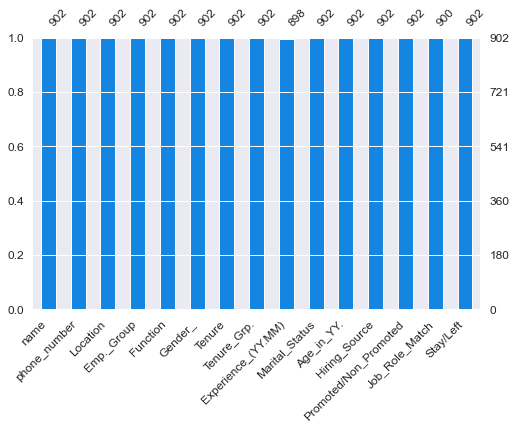

In [193]:
msno.bar(train, color = '#1585E2',fontsize=12,figsize = (8, 5))

<AxesSubplot:>

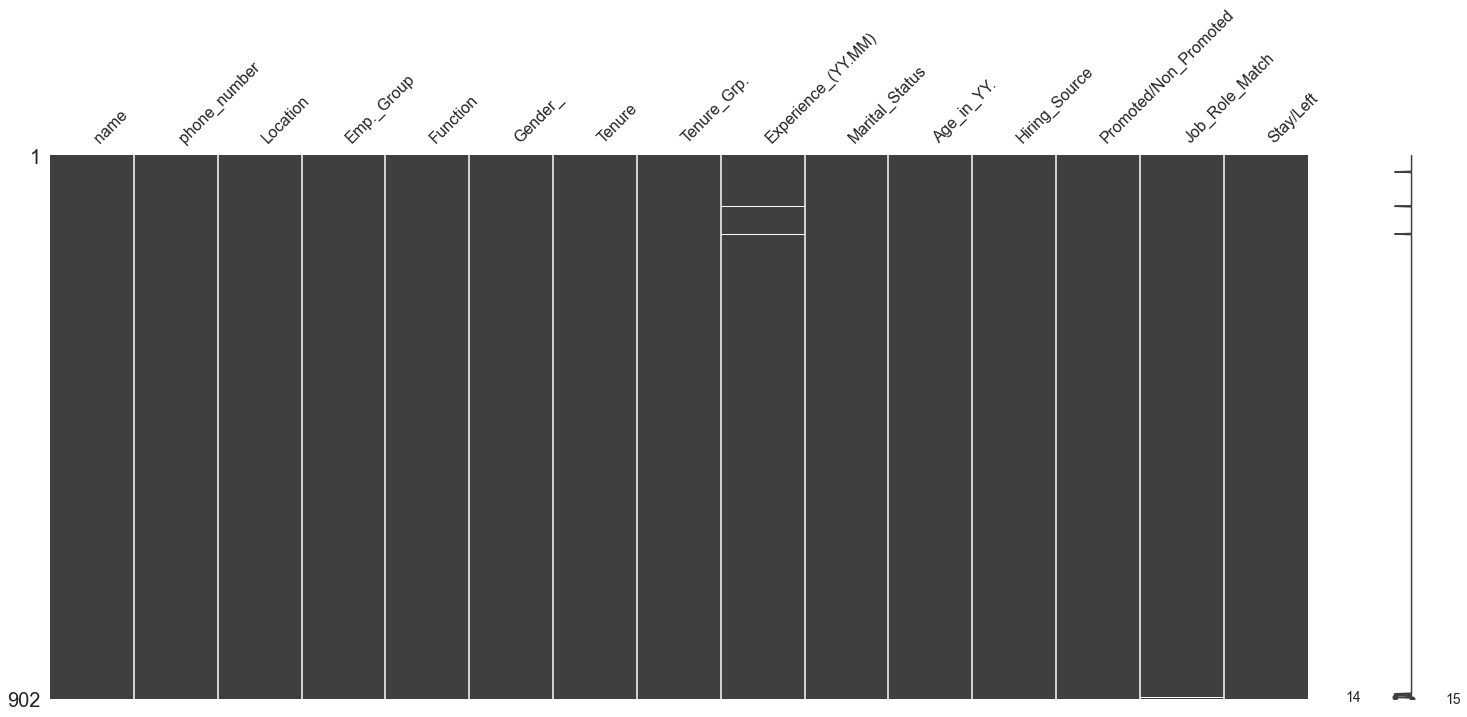

In [194]:
msno.matrix(train)


<AxesSubplot:>

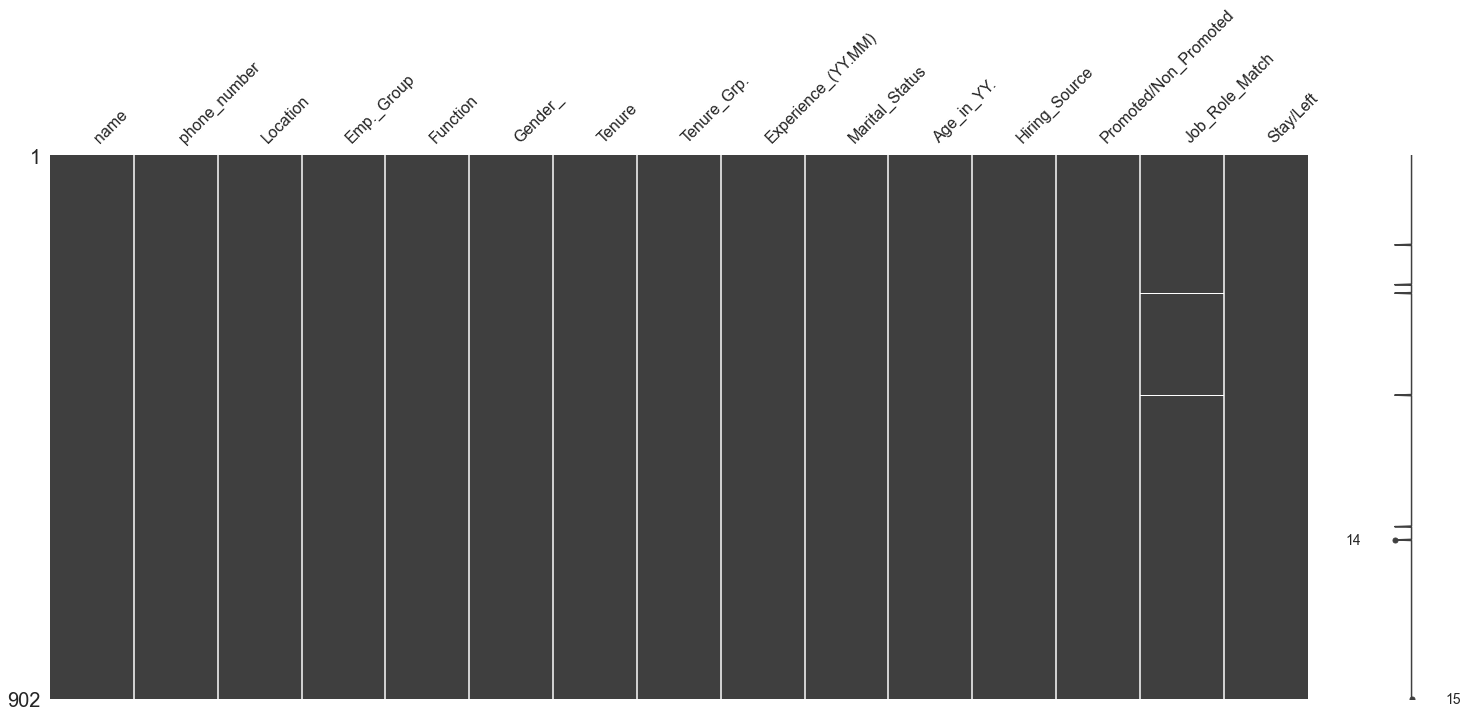

In [195]:
#sorted by gender
sorted = train.sort_values('Gender_')
msno.matrix(sorted)

<AxesSubplot:>

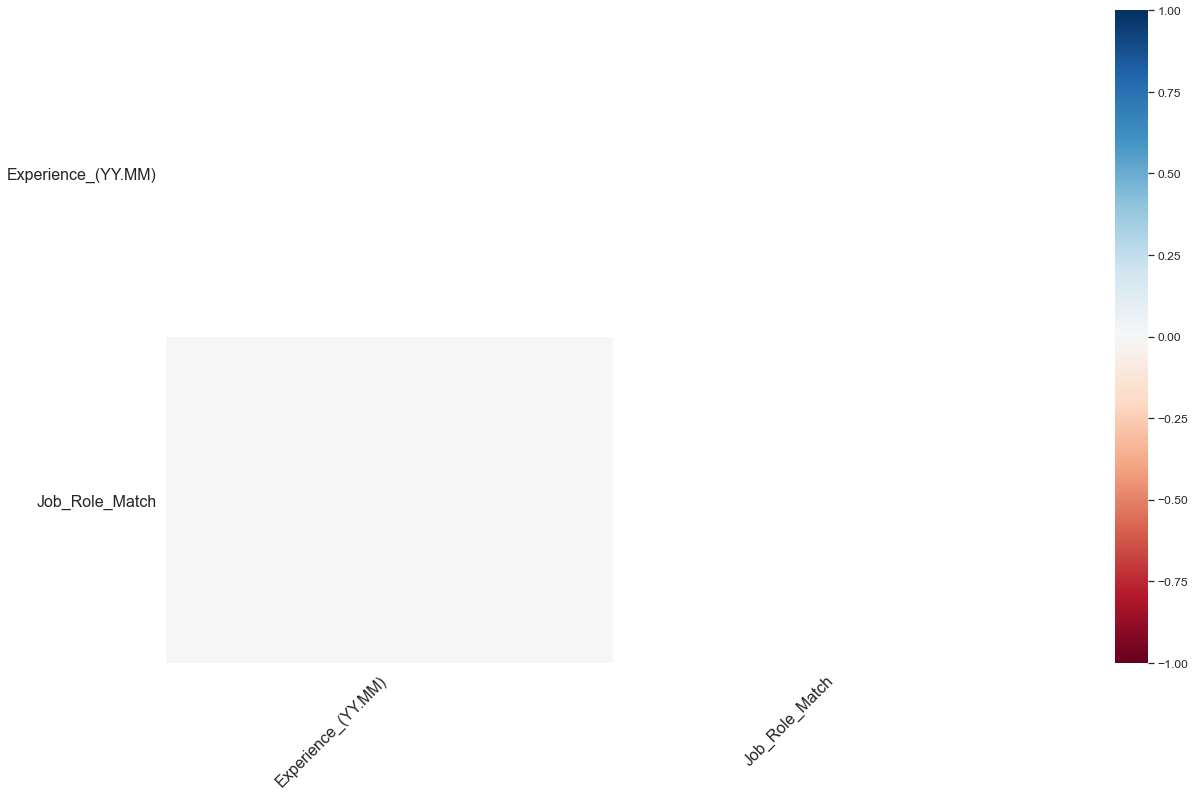

In [196]:
msno.heatmap(train)

<AxesSubplot:>

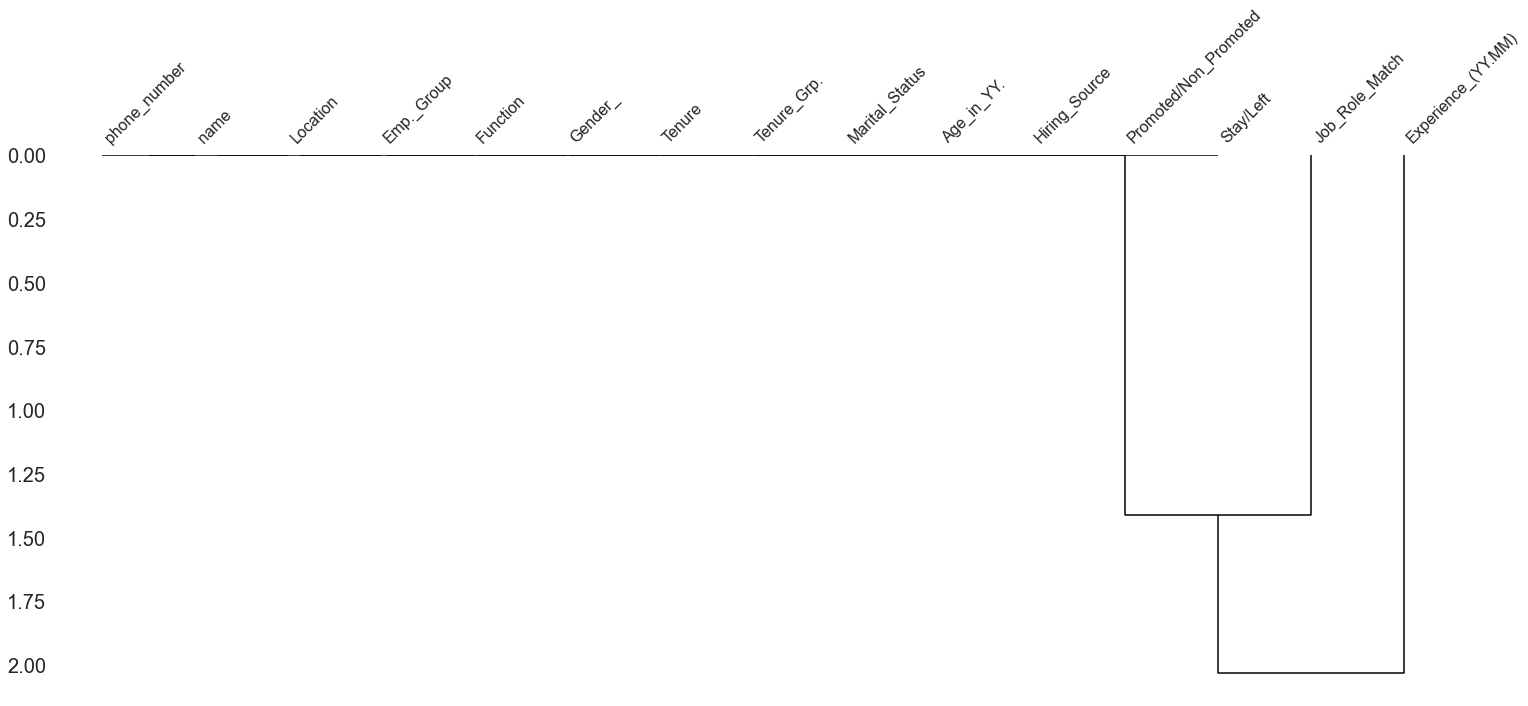

In [197]:
msno.dendrogram(train)

**Let's remove selected columns/rows with missing values.**

** Since there is no clear understanding/portion of missing columns, I don't plan to drop any columns from the list ** 

### Imputation

### New imputation technique: using regression model


<AxesSubplot:>

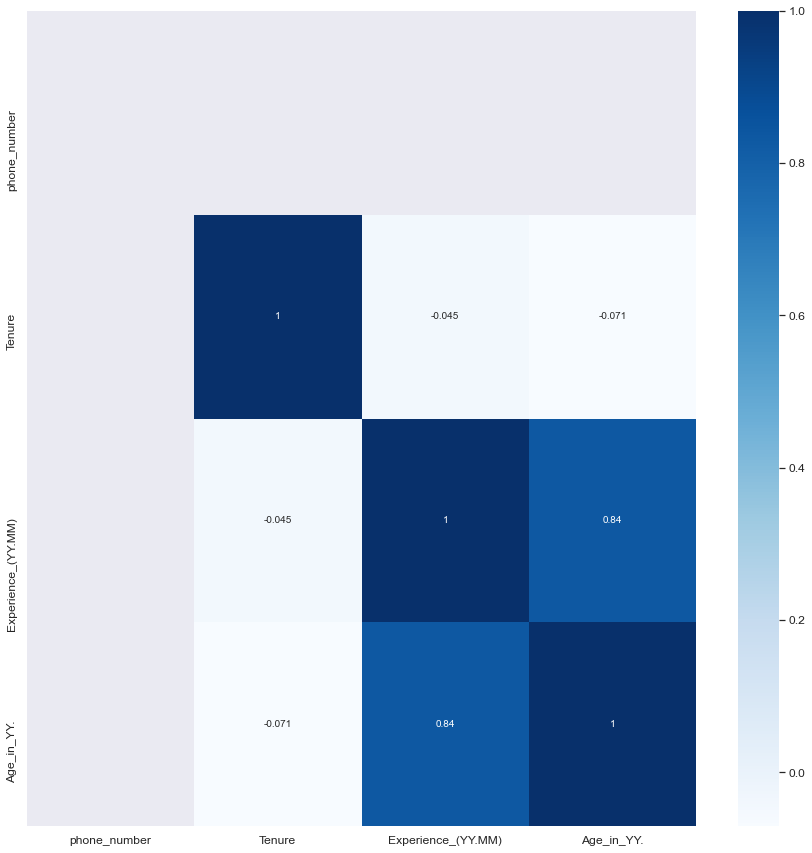

In [198]:
plt.subplots(figsize=(15,15))
data = train.corr()
sns.heatmap(data, cmap ='Blues', annot=True, annot_kws={"size": 10})

In [199]:
def regressor_inputer(df, output_column, input_column, decimals=2):
    
    display(Markdown('**Results:**'))
    #Missing values from Output column
    missing_output = df[output_column].isnull()
    print("Number of missing values in column: {} => {}".format(output_column,missing_output.sum() ))
    
    df_regressor = df.dropna(axis=0, subset = [output_column,input_column])
    df_regressor = df_regressor.loc[:,[output_column,input_column]]
    #Input column observations with Output column missing
    input_column_with_missing_output_column = pd.DataFrame(df[input_column][missing_output])
    input_column_with_missing_output_column = input_column_with_missing_output_column.dropna()
    #Creating regressor model
    x = df_regressor[[input_column]]
    y = df_regressor[[output_column]]
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    lm = LinearRegression().fit(x_train,y_train)
    print(f'R2 value in validation partition: {lm.score(x_val, y_val)}')
    #Predicting output column
    predictor = df[input_column][ df[output_column].isnull()  &  ~df[input_column].isnull() ] 
    predictor = pd.DataFrame(predictor)
    predictor[output_column]=  lm.predict( predictor[[input_column]] ) 
    df.loc[ df[output_column].isnull()  &  ~df[input_column].isnull() ,[output_column]] = predictor[output_column].round(decimals)
    print("New number of missing values in column: {} => {}".format(output_column, df[output_column].isnull().sum() ))
    return df
    #NOT CLEAR ON THIS FUNCTION 

In [200]:
#train = regressor_inputer(train,'company_size',0)

In [201]:
missing_values_table(train)

**Results:**

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Experience_(YY.MM),4,0.4
Job_Role_Match,2,0.2


<strong>Let's use mean/mode/median technique to impute missing values for column(s) identified in previous step.</strong>

In [202]:
mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

In [203]:
train["Experience_(YY.MM)"] = most_frequent_imputer.fit_transform(train[["Experience_(YY.MM)"]])
train["Job_Role_Match"] = most_frequent_imputer.fit_transform(train[["Job_Role_Match"]])


<strong>Now, let's check the missingness of the dataset.</strong>

In [204]:
missing_values_table(train)

**Results:**

Your selected dataframe has 15 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


 #### Transforming Columns

<strong>Let's review object columns.</strong>

In [205]:
print("Column data types and their frequency\n{}".format(train.dtypes.value_counts()))

Column data types and their frequency
object     11
float64     3
int64       1
dtype: int64


In [206]:
train.dtypes

name                      object
phone_number               int64
Location                  object
Emp._Group                object
Function                  object
Gender_                   object
Tenure                   float64
Tenure_Grp.               object
Experience_(YY.MM)       float64
Marital_Status            object
Age_in_YY.               float64
Hiring_Source             object
Promoted/Non_Promoted     object
Job_Role_Match            object
Stay/Left                 object
dtype: object

In [207]:
def check_object_columns(df):
    object_columns_df = df.select_dtypes(include=['object'])
    print(object_columns_df.iloc[0])
    i=0
    for col in object_columns_df:
        if is_numeric_dtype(df[col]):
            i+=1
            print(f"{col.ljust(25)}" + ' ==> is Numeric')
    if i==0:
        display(Markdown('**Results:**'))
        print('No numeric columns were found')

In [208]:
check_object_columns(train)

name                              sid
Location                         Pune
Emp._Group                         B2
Function                    Operation
Gender_                          Male
Tenure_Grp.                      < =1
Marital_Status                 Single
Hiring_Source                  Direct
Promoted/Non_Promoted    Non Promoted
Job_Role_Match                    Yes
Stay/Left                        Left
Name: 0, dtype: object


**Results:**

No numeric columns were found


** Let's convert columns **

In [209]:
def columns_to_numeric(df,columns_to_convert = []):
    display(Markdown('**Results:**'))
    for col in columns_to_convert:
        if col in df.columns:
            if is_numeric_dtype(df[col]):
                df[col] = df[col].str.rstrip('%').astype('float')
                print("Column {} was converted".format(col))
            else:
                print("Column {} could not be converted".format(col))
        else:
            print("Column {} does not exist".format(col))
    return df

In [210]:
train = columns_to_numeric(train,[])
# Not sure why giving error on float columns ==> it only applies to STRING columns with numeric values

**Results:**

<div class="alert alert-block alert-info">
<b><h1>3. Exploratory Data Analysis</h1></div>
</a><a class="anchor" id="exploration"></a>

EDA is the process of performing initial investigations on data so as to:

<li>Uncover underlying structure & patterns in the data
<li>Identify important variables
<li>Identify anomalies
<li>Test a hypothesis
<li>Check assumptions
<li>Set the stage for model development

Exploratory Data Analysis is like listening to what the data can tell us before we start the actual modeling process for a head start. 

** Let's do some data visualization! We'll use seaborn and pandas built-in plotting capabilities.**

Target column is assigned to l_target variable.

In [211]:
l_target = 'Stay/Left'

<div class="alert alert-block alert-warning">
<b>3.1 Univariate Analysis</b>
</div> </a><a class="anchor" id="univariate"></a>

<strong>Let's quick review target column values/distribution.</strong>

In [212]:
list_column_values_percentage(train,15)

**Results:**

Columns with less than 15 values
Arnab     0.342572
Papu      0.222838
Dwane     0.170732
Shiv      0.140798
shruti    0.084257
sid       0.021064
Rahul     0.017738
Name: name, dtype: float64
9876544345    1.0
Name: phone_number, dtype: float64
Chennai       0.282705
Noida         0.261641
Bangalore     0.232816
Hyderabad     0.073171
Pune          0.062084
Madurai       0.032151
Lucknow       0.022173
Nagpur        0.015521
Vijayawada    0.008869
Mumbai        0.004435
Gurgaon       0.003326
Kolkata       0.001109
Name: Location, dtype: float64
B1    0.601996
B2    0.305987
B3    0.065410
B0    0.008869
B4    0.007761
B5    0.004435
B7    0.002217
D2    0.001109
B6    0.001109
C3    0.001109
Name: Emp._Group, dtype: float64
Operation    0.929047
Support      0.057650
Sales        0.013304
Name: Function, dtype: float64
Male      0.730599
Female    0.262749
other     0.006652
Name: Gender_, dtype: float64
> 1 & < =3    0.694013
< =1          0.305987
Name: Tenure_Grp., dtype: float64


In [213]:
def plot_target_column (df, target):
    ax = sns.countplot(x=target, data=df)
    plt.title('Distribution of ' + target + ' column')
    plt.xlabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    total = len(df[target])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
            ax.text(p.get_x()+p.get_width()/2., p.get_height() + 0.2, p.get_height(),ha="center")
    plt.show()

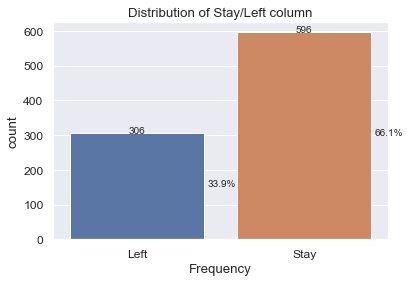

In [214]:
plot_target_column(train, l_target)

** Let's do again a quick review of list of values per each column **

In [215]:
list_column_values(train,15,'True')

**Results:**

name                      ==> ['Arnab', 'Dwane', 'Papu', 'Rahul', 'Shiv', 'shruti', 'sid']
phone_number              ==> [9876544345]
Location                  ==> ['Bangalore', 'Chennai', 'Gurgaon', 'Hyderabad', 'Kolkata', 'Lucknow', 'Madurai', 'Mumbai', 'Nagpur', 'Noida', 'Pune', 'Vijayawada']
Emp._Group                ==> ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'C3', 'D2']
Function                  ==> ['Operation', 'Sales', 'Support']
Gender_                   ==> ['Female', 'Male', 'other']
Tenure                    ==> more than 15 values
Tenure_Grp.               ==> ['< =1', '> 1 & < =3']
Experience_(YY.MM)        ==> more than 15 values
Marital_Status            ==> ['Div.', 'Marr.', 'NTBD', 'Sep.', 'Single']
Age_in_YY.                ==> more than 15 values
Hiring_Source             ==> ['Agency', 'Direct', 'Employee Referral']
Promoted/Non_Promoted     ==> ['Non Promoted', 'Promoted']
Job_Role_Match            ==> ['No', 'Yes']
Stay/Left                 ==> ['Left',

**Let's plot categorical columns.**

In [216]:
def plot_categorical_columns(df):
    categorical = train.select_dtypes(exclude=['int', 'float']).columns
    lcols_in_plot = 2
    lrows_in_plot = math.ceil(len(categorical)/lcols_in_plot)   
    fig, ax = plt.subplots( lrows_in_plot, lcols_in_plot , figsize=(20, 30))
    plt.subplots_adjust(wspace=0.2, hspace=1) 
    sns.set(font_scale = 1.1)
    for variable, subplot in zip(categorical, ax.flatten()):
        sns.countplot(train[variable], ax=subplot)
        for label in subplot.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
            label.set_rotation_mode("anchor")

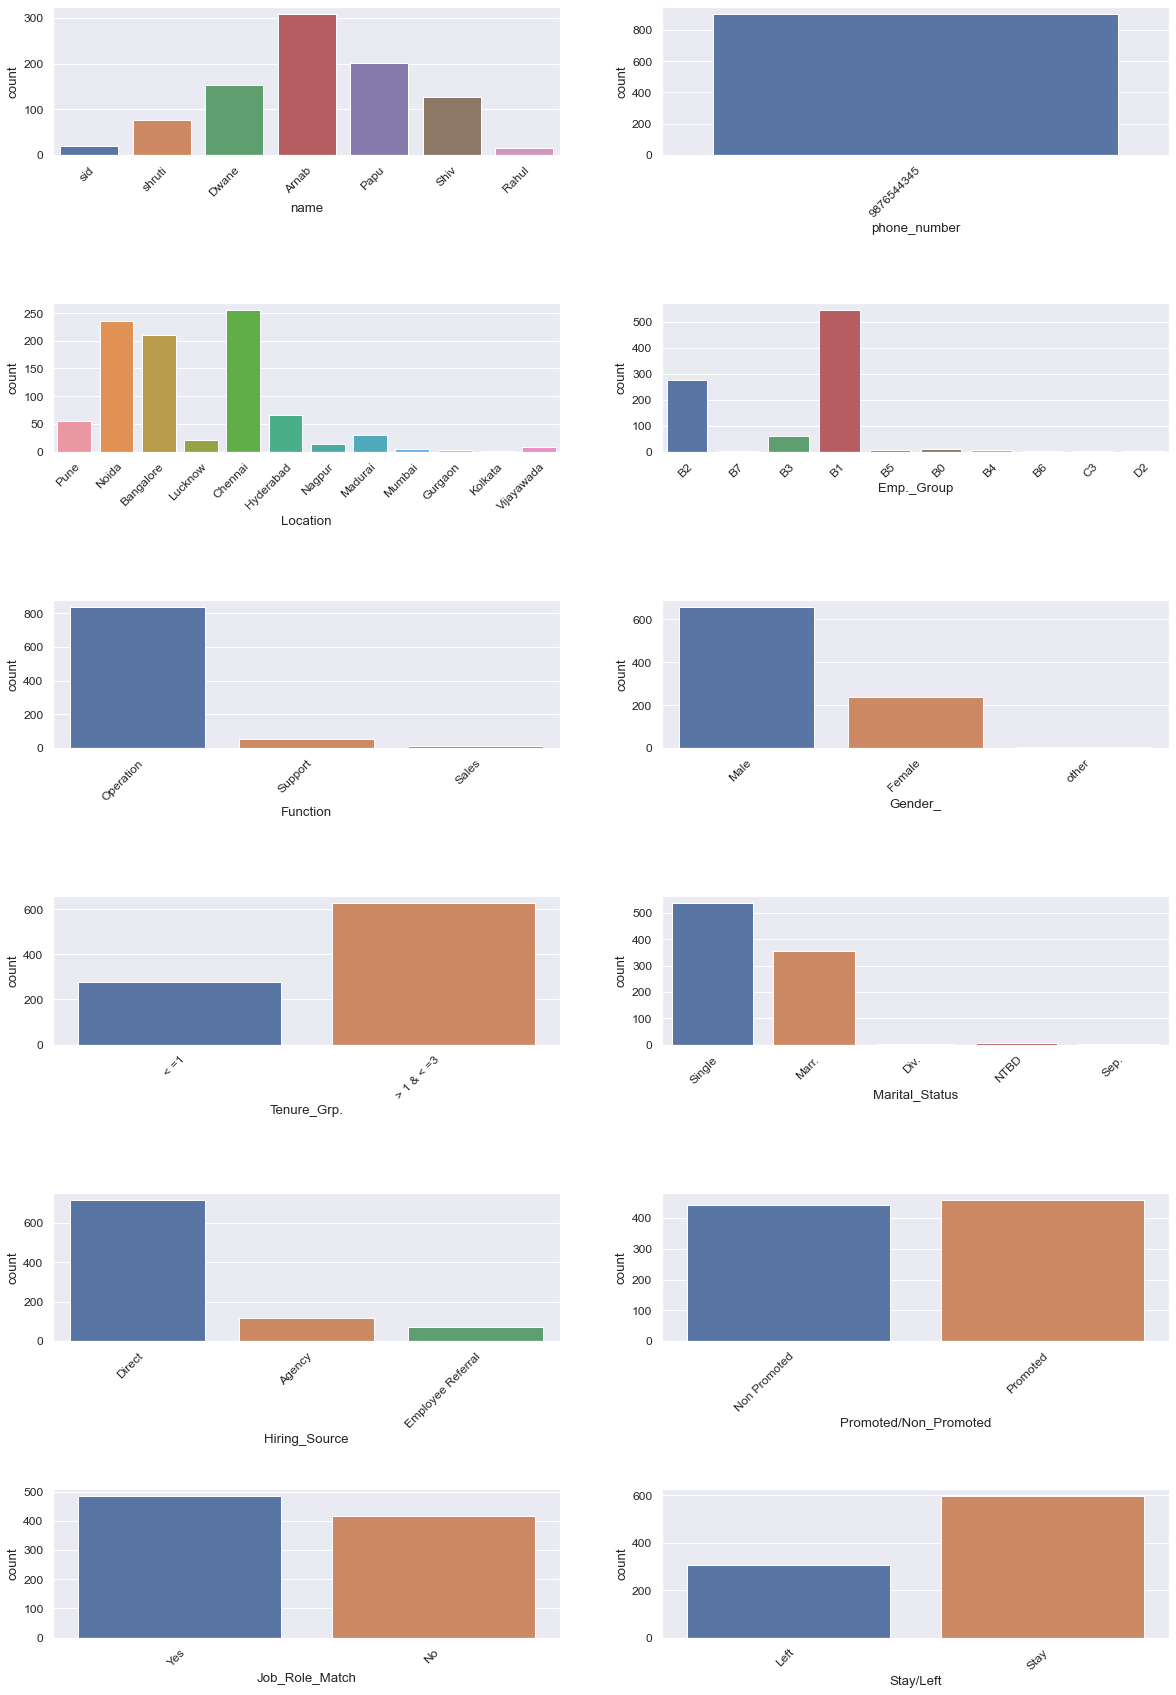

In [217]:
plot_categorical_columns(train)

** Let's plot numerical columns. Using standard and customized function.**

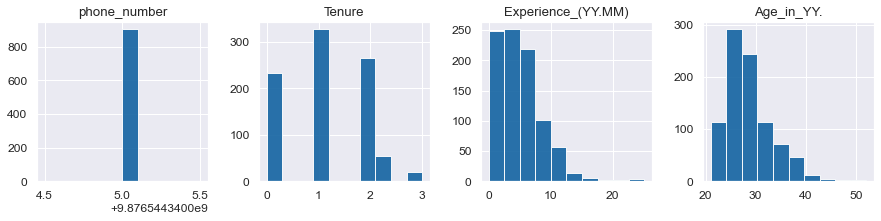

In [218]:
hist = train.hist(figsize = (15, 22), layout=(6, 4) , color='#1363a1',alpha=0.9 )

In [219]:
def plot_numerical_columns(df):
    df = df[df.select_dtypes([np.int64,np.float64]).columns]
    lcols = 2
    lrows = math.ceil(len(df.columns)/lcols)
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.5) 
    for i, column in enumerate(df.columns):
        plt.subplot(lrows,lcols,i+1)
        sns.distplot(df[column])

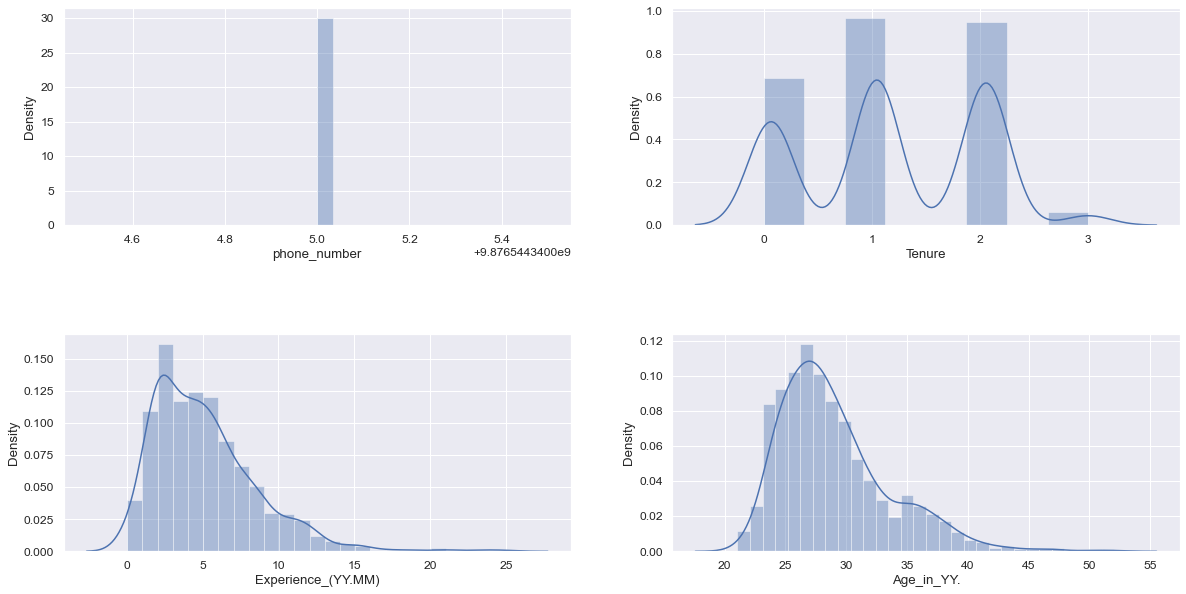

In [220]:
plot_numerical_columns(train)
### Not sure why I get this error

In [221]:
train.select_dtypes(include=object)

,name,Location,Emp._Group,Function,Gender_,Tenure_Grp.,Marital_Status,Hiring_Source,Promoted/Non_Promoted,Job_Role_Match,Stay/Left
0,sid,Pune,B2,Operation,Male,< =1,Single,Direct,Non Promoted,Yes,Left
1,sid,Noida,B7,Support,Male,< =1,Marr.,Direct,Promoted,No,Stay
2,sid,Bangalore,B3,Operation,Male,< =1,Marr.,Direct,Promoted,Yes,Stay
3,sid,Noida,B2,Operation,Male,< =1,Marr.,Direct,Promoted,Yes,Stay
4,sid,Lucknow,B2,Operation,Male,< =1,Marr.,Direct,Non Promoted,Yes,Stay
...,...,...,...,...,...,...,...,...,...,...,...
897,Rahul,Vijayawada,B1,Operation,Female,< =1,Single,Direct,Non Promoted,Yes,Stay
898,Rahul,Vijayawada,B1,Operation,Female,< =1,Single,Direct,Non Promoted,Yes,Left
899,Rahul,Vijayawada,B1,Operation,Female,< =1,Single,Direct,Non Promoted,Yes,Left
900,Rahul,Vijayawada,B1,Operation,Female,< =1,Single,Direct,Non Promoted,Yes,Stay


In [222]:
train.dtypes

name                      object
phone_number               int64
Location                  object
Emp._Group                object
Function                  object
Gender_                   object
Tenure                   float64
Tenure_Grp.               object
Experience_(YY.MM)       float64
Marital_Status            object
Age_in_YY.               float64
Hiring_Source             object
Promoted/Non_Promoted     object
Job_Role_Match            object
Stay/Left                 object
dtype: object

<div class="alert alert-block alert-warning">
<b>3.2 Bi-variate Analysis</b>
</div> </a><a class="anchor" id="bivariate"></a>

**Let's use crosstab function.**


In [223]:
train

,name,phone_number,Location,Emp._Group,Function,Gender_,Tenure,Tenure_Grp.,Experience_(YY.MM),Marital_Status,Age_in_YY.,Hiring_Source,Promoted/Non_Promoted,Job_Role_Match,Stay/Left
0,sid,9876544345,Pune,B2,Operation,Male,0.00,< =1,6.08,Single,27.12,Direct,Non Promoted,Yes,Left
1,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay
2,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay
3,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay
4,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,21.09,Direct,Non Promoted,Yes,Stay
898,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,22.02,Direct,Non Promoted,Yes,Left
899,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,22.01,Direct,Non Promoted,Yes,Left
900,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,22.02,Direct,Non Promoted,Yes,Stay


In [224]:
col = train.Gender_
pd.crosstab(train[l_target], [col], margins=True, margins_name="Total", normalize='index')

Gender_,Female,Male,other
Stay/Left,,,
Left,0.238562,0.754902,0.006536
Stay,0.275168,0.718121,0.006711
Total,0.262749,0.730599,0.006652


In [225]:
col = train.Function
pd.crosstab(train[l_target], [col], margins=True, margins_name="Total")
# These values are using absolute numbers

Function,Operation,Sales,Support,Total
Stay/Left,,,,
Left,282,4,20,306
Stay,556,8,32,596
Total,838,12,52,902


** pairplot() takes a broader view, showing all pairwise relationships and the marginal distributions, optionally conditioned on a categorical variable :**

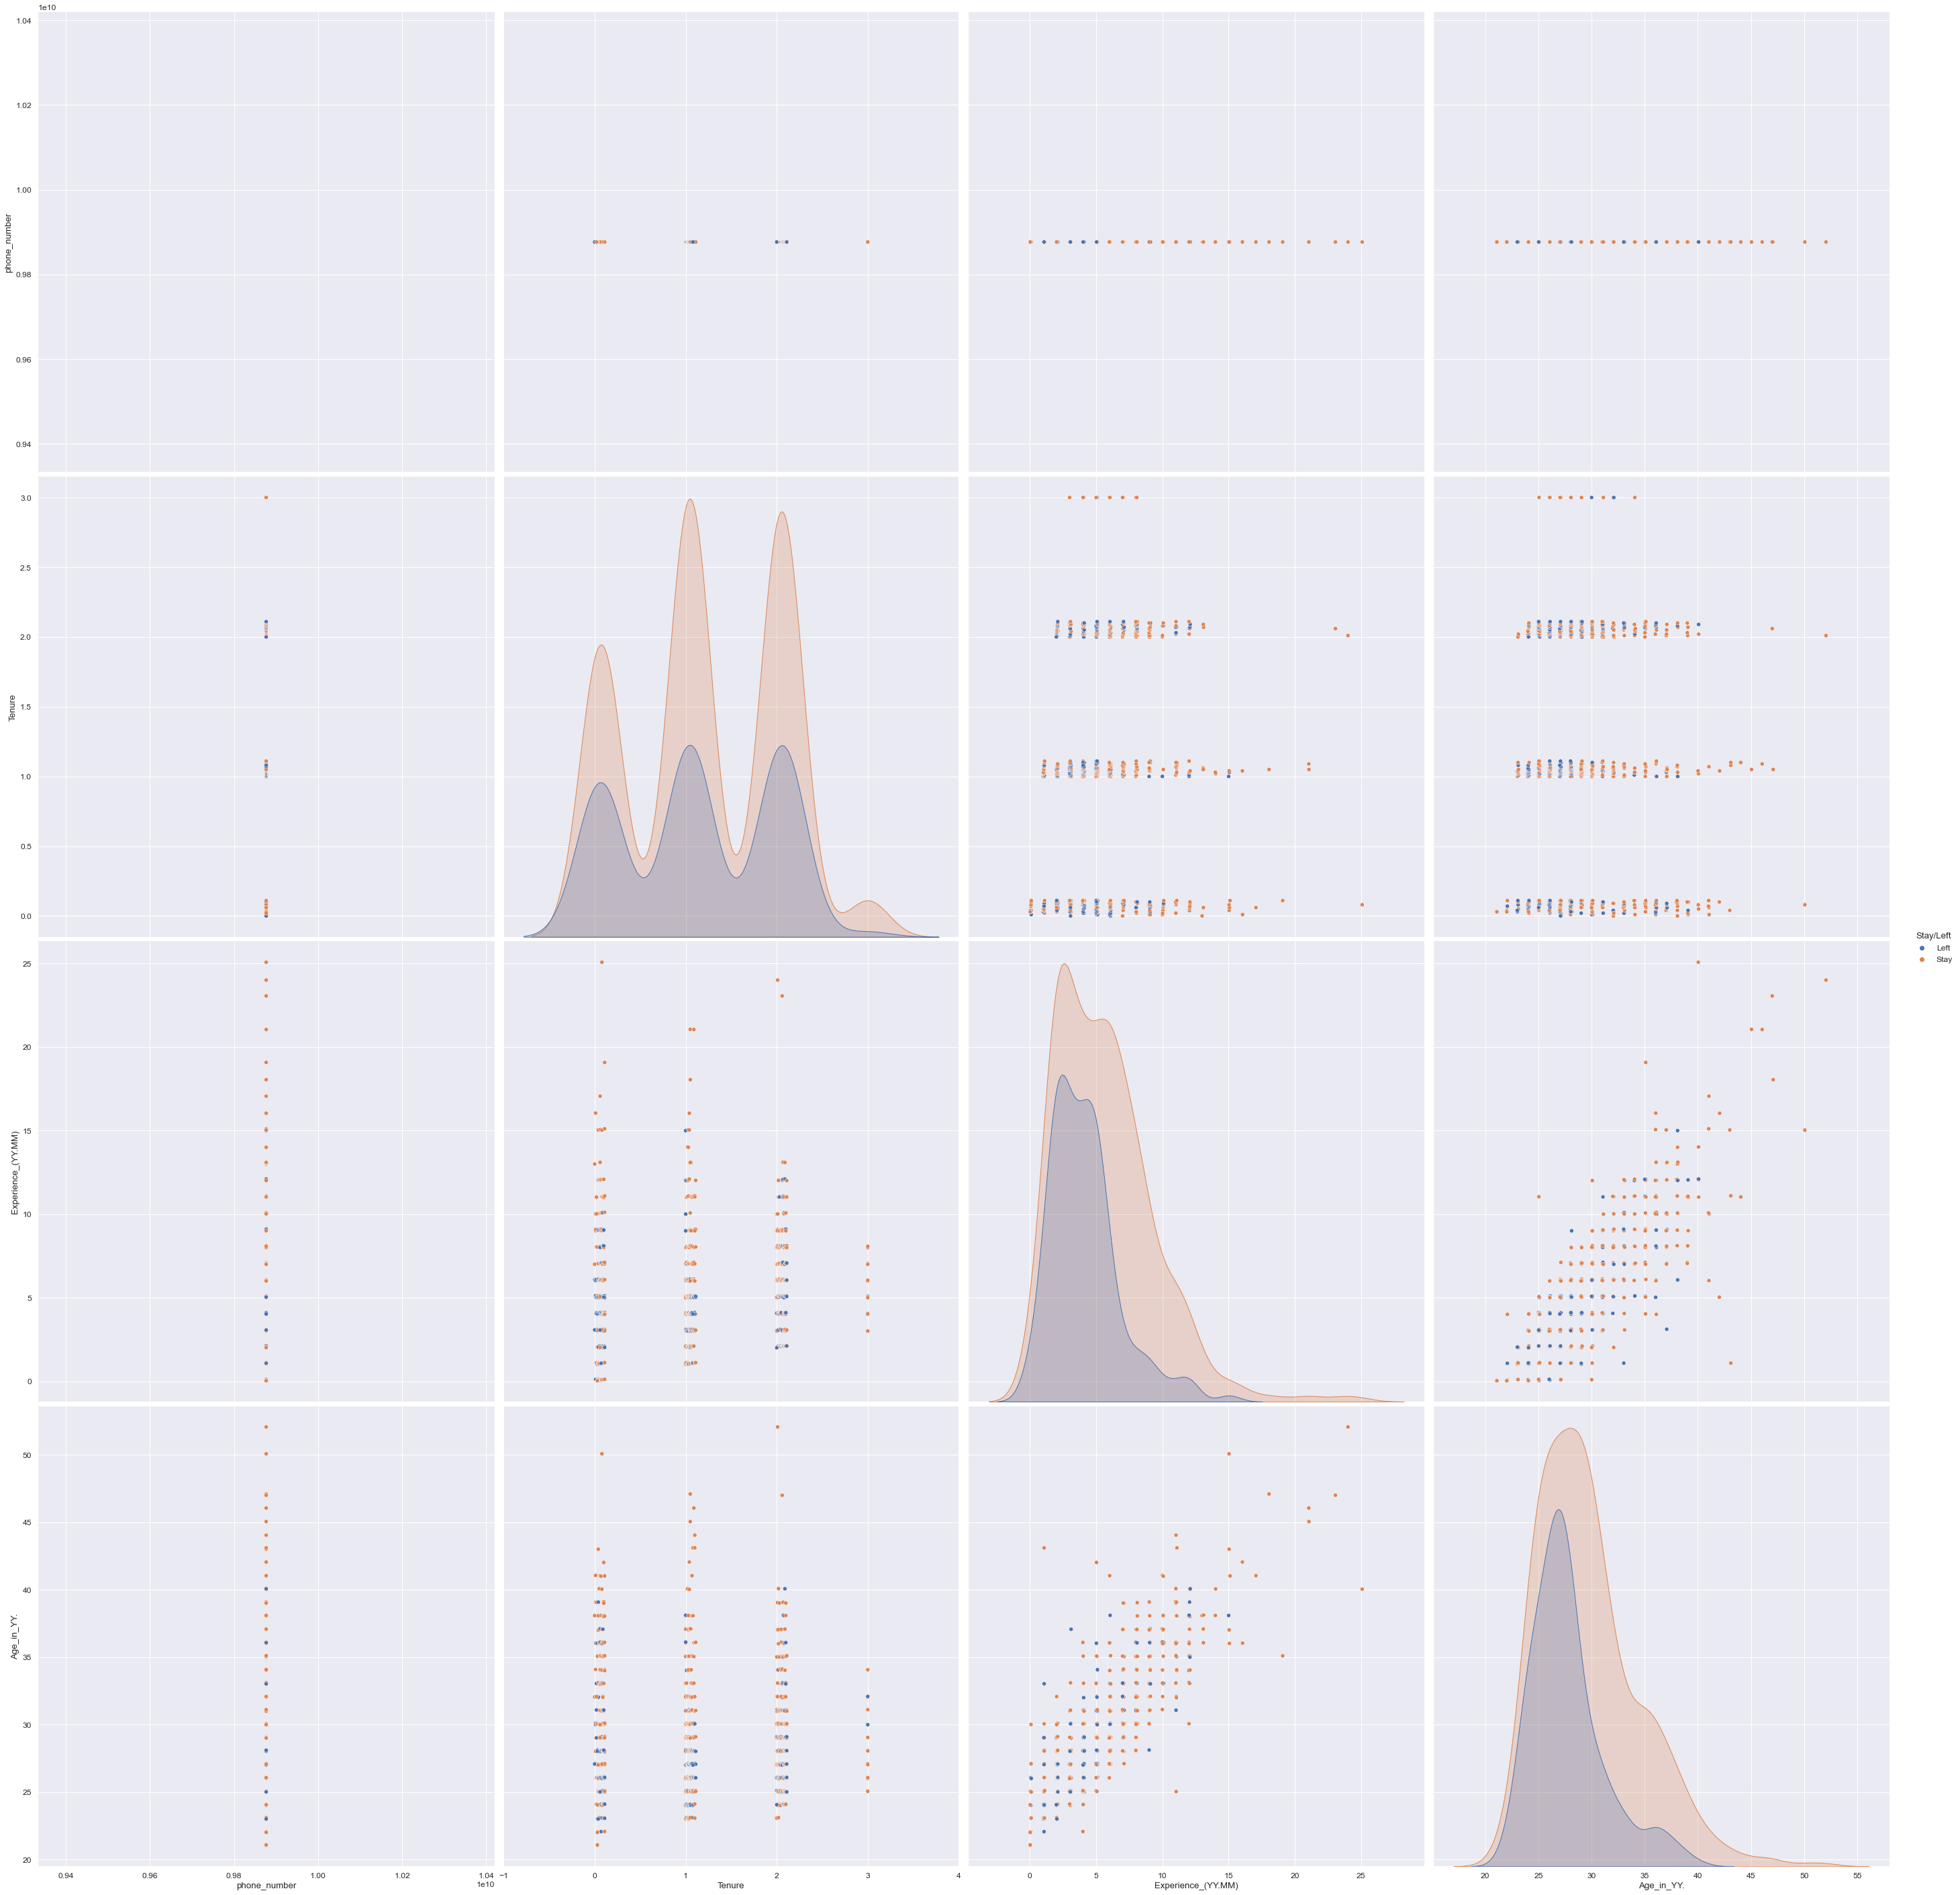

In [226]:
sns.pairplot(data=train, hue=l_target,  height=10);

In [227]:
train

,name,phone_number,Location,Emp._Group,Function,Gender_,Tenure,Tenure_Grp.,Experience_(YY.MM),Marital_Status,Age_in_YY.,Hiring_Source,Promoted/Non_Promoted,Job_Role_Match,Stay/Left
0,sid,9876544345,Pune,B2,Operation,Male,0.00,< =1,6.08,Single,27.12,Direct,Non Promoted,Yes,Left
1,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay
2,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay
3,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay
4,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,21.09,Direct,Non Promoted,Yes,Stay
898,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,22.02,Direct,Non Promoted,Yes,Left
899,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,22.01,Direct,Non Promoted,Yes,Left
900,Rahul,9876544345,Vijayawada,B1,Operation,Female,0.03,< =1,0.03,Single,22.02,Direct,Non Promoted,Yes,Stay


<div class="alert alert-block alert-info">
<b><h1>4. Feature Engineering</h1></div>
</a><a class="anchor" id="engineering"></a>

<strong>Let's move original tables to new ones.</strong>

In [228]:
train1 = train.copy()

In [229]:
print("Column data types and their frequency\n{}".format(train1.dtypes.value_counts()))

Column data types and their frequency
object     11
float64     3
int64       1
dtype: int64


In [230]:
list_column_values(train1,15,'True')

**Results:**

name                      ==> ['Arnab', 'Dwane', 'Papu', 'Rahul', 'Shiv', 'shruti', 'sid']
phone_number              ==> [9876544345]
Location                  ==> ['Bangalore', 'Chennai', 'Gurgaon', 'Hyderabad', 'Kolkata', 'Lucknow', 'Madurai', 'Mumbai', 'Nagpur', 'Noida', 'Pune', 'Vijayawada']
Emp._Group                ==> ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'C3', 'D2']
Function                  ==> ['Operation', 'Sales', 'Support']
Gender_                   ==> ['Female', 'Male', 'other']
Tenure                    ==> more than 15 values
Tenure_Grp.               ==> ['< =1', '> 1 & < =3']
Experience_(YY.MM)        ==> more than 15 values
Marital_Status            ==> ['Div.', 'Marr.', 'NTBD', 'Sep.', 'Single']
Age_in_YY.                ==> more than 15 values
Hiring_Source             ==> ['Agency', 'Direct', 'Employee Referral']
Promoted/Non_Promoted     ==> ['Non Promoted', 'Promoted']
Job_Role_Match            ==> ['No', 'Yes']
Stay/Left                 ==> ['Left',

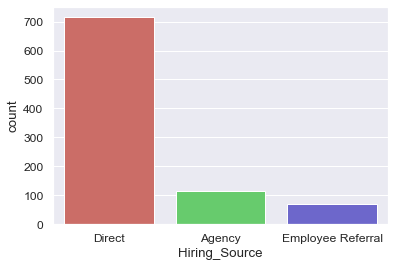

In [231]:
sns.countplot(x='Hiring_Source',data=train1, palette='hls')
plt.show();

<div class="alert alert-block alert-warning">
<b>4.1 General Transformation</b>
</div> </a><a class="anchor" id="general_trans"></a>

<strong>Let's replace categorical values with numerical values.</strong>

In [232]:
list_column_values(train1,15,'True')

**Results:**

name                      ==> ['Arnab', 'Dwane', 'Papu', 'Rahul', 'Shiv', 'shruti', 'sid']
phone_number              ==> [9876544345]
Location                  ==> ['Bangalore', 'Chennai', 'Gurgaon', 'Hyderabad', 'Kolkata', 'Lucknow', 'Madurai', 'Mumbai', 'Nagpur', 'Noida', 'Pune', 'Vijayawada']
Emp._Group                ==> ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'C3', 'D2']
Function                  ==> ['Operation', 'Sales', 'Support']
Gender_                   ==> ['Female', 'Male', 'other']
Tenure                    ==> more than 15 values
Tenure_Grp.               ==> ['< =1', '> 1 & < =3']
Experience_(YY.MM)        ==> more than 15 values
Marital_Status            ==> ['Div.', 'Marr.', 'NTBD', 'Sep.', 'Single']
Age_in_YY.                ==> more than 15 values
Hiring_Source             ==> ['Agency', 'Direct', 'Employee Referral']
Promoted/Non_Promoted     ==> ['Non Promoted', 'Promoted']
Job_Role_Match            ==> ['No', 'Yes']
Stay/Left                 ==> ['Left',

<strong>Let's convert remaining object columns to strings.</strong>

In [233]:
def object_to_str(df, to_str_cols):
    for col in to_str_cols:
        df[col] = df[col].astype(str)
    return df

** I don't have any columns with values left as string. So leaving it as is **

<div class="alert alert-block alert-warning">
<b>4.2 Encoding</b>
</div> </a><a class="anchor" id="encoding"></a>

In [234]:
train1.head()

,name,phone_number,Location,Emp._Group,Function,Gender_,Tenure,Tenure_Grp.,Experience_(YY.MM),Marital_Status,Age_in_YY.,Hiring_Source,Promoted/Non_Promoted,Job_Role_Match,Stay/Left
0,sid,9876544345,Pune,B2,Operation,Male,0.00,< =1,6.08,Single,27.12,Direct,Non Promoted,Yes,Left
1,sid,9876544345,Noida,B7,Support,Male,0.00,< =1,13.00,Marr.,38.08,Direct,Promoted,No,Stay
2,sid,9876544345,Bangalore,B3,Operation,Male,0.01,< =1,16.05,Marr.,36.04,Direct,Promoted,Yes,Stay
3,sid,9876544345,Noida,B2,Operation,Male,0.01,< =1,6.06,Marr.,32.07,Direct,Promoted,Yes,Stay
4,sid,9876544345,Lucknow,B2,Operation,Male,0.00,< =1,7.00,Marr.,32.05,Direct,Non Promoted,Yes,Stay


In [235]:
print("Column data types and their frequency\n{}".format(train1.dtypes.value_counts()))

Column data types and their frequency
object     11
float64     3
int64       1
dtype: int64


<strong>LABEL ENCODER</strong>

<strong> It Doesn't looks like that I need to use any of the encoding methods</strong>

In [236]:
from sklearn.preprocessing import LabelEncoder

encode_cols = ['name','Location','Emp._Group','Function','Gender_','Tenure_Grp.',
              'Marital_Status','Hiring_Source','Promoted/Non_Promoted','Job_Role_Match']


def labelencpode(df):
    enc = LabelEncoder()
    for col in encode_cols:
        enc.fit(df[col])
        df[col] = enc.transform(df[col])
    return df

train1 = labelencpode(train1)



In [237]:
def one_hot_encoder(df, cat_cols = ['city','gender','major_discipline','company_type']):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=cat_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [238]:
#cat_cols = ['city','gender','major_discipline','company_type']
#train1 = one_hot_encoder(train1,cat_cols)

In [239]:
train1.head()

,name,phone_number,Location,Emp._Group,Function,Gender_,Tenure,Tenure_Grp.,Experience_(YY.MM),Marital_Status,Age_in_YY.,Hiring_Source,Promoted/Non_Promoted,Job_Role_Match,Stay/Left
0,6,9876544345,10,2,0,1,0.00,0,6.08,4,27.12,1,0,1,Left
1,6,9876544345,9,7,2,1,0.00,0,13.00,1,38.08,1,1,0,Stay
2,6,9876544345,0,3,0,1,0.01,0,16.05,1,36.04,1,1,1,Stay
3,6,9876544345,9,2,0,1,0.01,0,6.06,1,32.07,1,1,1,Stay
4,6,9876544345,5,2,0,1,0.00,0,7.00,1,32.05,1,0,1,Stay


In [240]:
train1.drop('phone_number', axis=1, inplace=True)

# SCALING

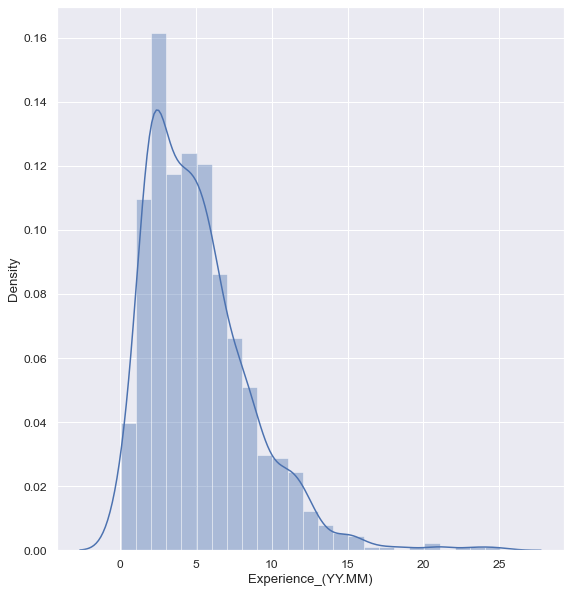

In [241]:
plot_numerical_columns(pd.DataFrame(train1['Experience_(YY.MM)']))

In [242]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


<div class="alert alert-block alert-info">
<b><h1>5. Model Training</h1></div>
<a class="anchor" id="training"></a>

<strong>Let's split the training dataset</strong>

In [243]:
train1['Stay/Left'] = train1['Stay/Left'].map({'Stay': 0, 'Left': 1})

In [244]:
y = train1[l_target].reset_index(drop=True)
X = train1.drop([l_target], axis=1)

In [245]:
X.shape, y.shape

((902, 13), (902,))

In [246]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import itertools
import timeit

<div class="alert alert-block alert-warning">
<b>5.1 Decision Tree</b>
</div> </a><a class="anchor" id="encoding"></a>

In [247]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [248]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

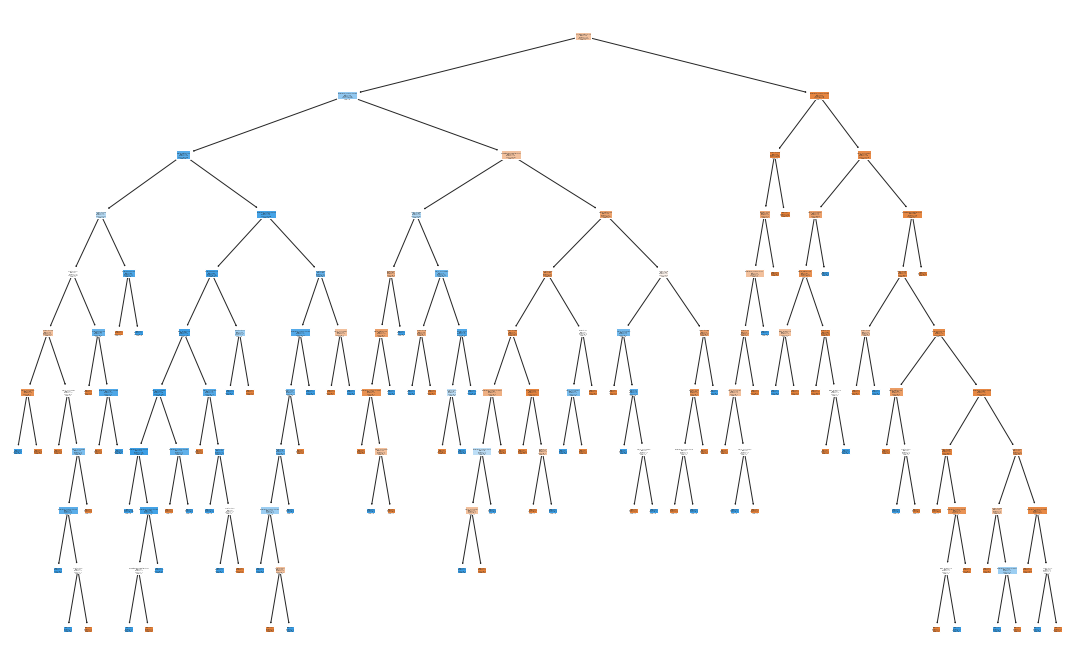

In [249]:
from sklearn.tree import plot_tree
plt.figure(figsize=(19,12))
features = train1.columns
classes = ['Y', 'N']
plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [250]:
def plot_learning_curve(clf, X, y, title=""):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusionmatrix(y_train,y_train_pred,dom):
    print(f'{dom} Confusion Matrix')
    cf = confusion_matrix(y_train,y_train_pred,[1,0])
    
    group_names = ['True Positives','False Positives','False Negatives','True Negatives']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf.flatten()/np.sum(cf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf, annot=labels, yticklabels=['Y', 'N'],xticklabels=['Y', 'N'], fmt='', cmap='Blues')
    plt.tight_layout()
    plt.show()
    
def plot_classification_report(y_train,y_train_pred,dom):
    print(f'{dom} Classification Report')
    clf_report = classification_report(y_train,
                                   y_train_pred,
                                   labels=[1,0],
                                   target_names=['Y', 'N'],
                                   output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True , cmap='Blues')
    plt.tight_layout()
    plt.show()    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test, title):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)

    plot_confusionmatrix(y_test,y_pred,dom=title)

    plot_classification_report(y_test,y_pred,dom=title)

In [251]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):

    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(1,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=5)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']

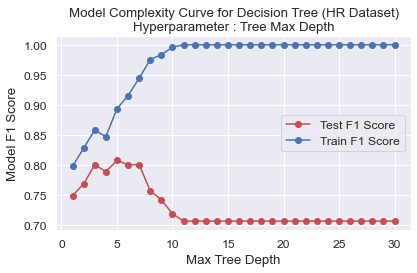

Per Hyperparameter tuning, best parameters are:
{'max_depth': 5, 'min_samples_leaf': 9}


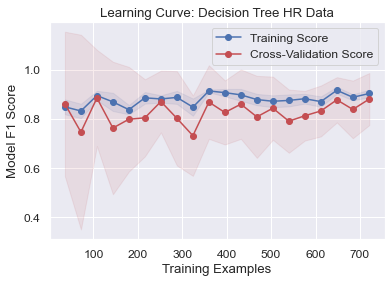

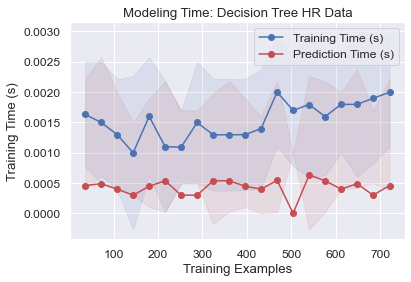

Test - Unseen Data Confusion Matrix


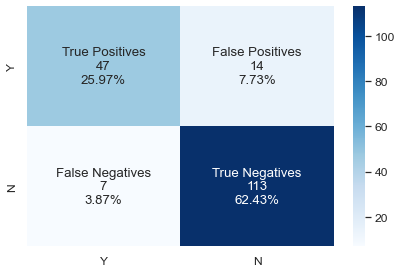

Test - Unseen Data Classification Report


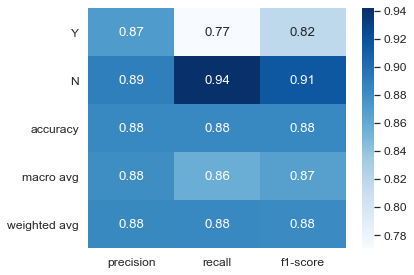

In [264]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperTree(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (HR Dataset)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_hr = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')

train_samp_hr, DT_train_score_hr, DT_fit_time_hr, DT_pred_time_hr = plot_learning_curve(estimator_hr, X_train, y_train,title="Decision Tree HR Data")

final_classifier_evaluation(estimator_hr, X_train, X_test, y_train, y_test, 'Test - Unseen Data')

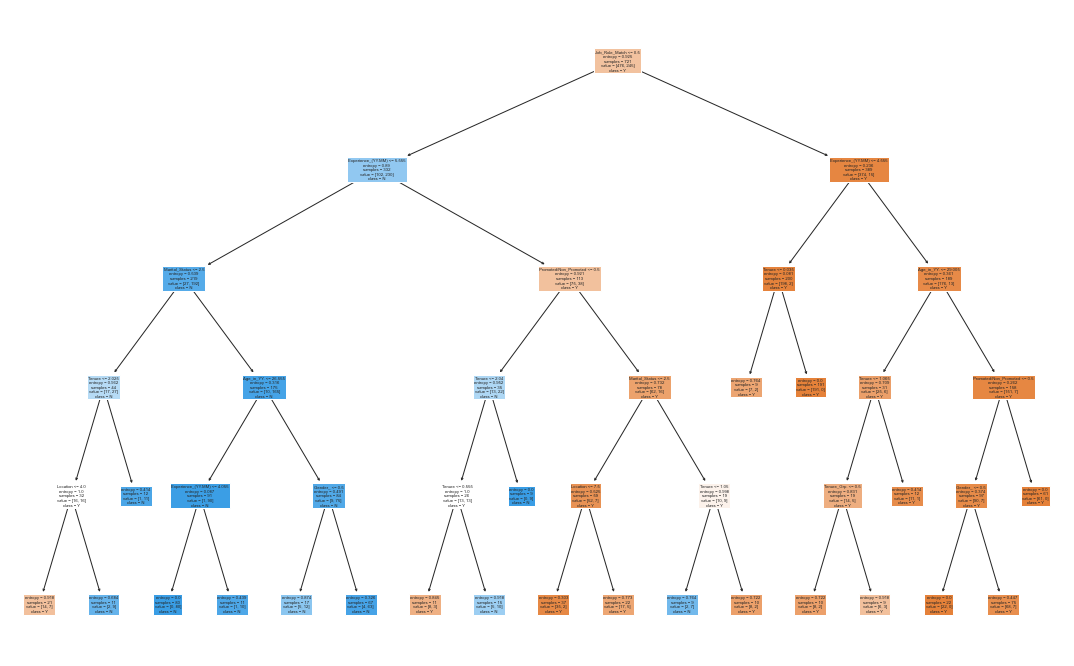

In [265]:
from sklearn.tree import plot_tree
plt.figure(figsize=(19,12))
features = train1.columns
classes = ['Y', 'N']
plot_tree(estimator_hr,feature_names=features,class_names=classes,filled=True)
plt.show()

<div class="alert alert-block alert-warning">
<b>5.2 Neural Network</b>
</div> </a><a class="anchor" id="encoding"></a>

In [253]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    lrlist = [ 0.005, 0.01,0.05,0.1,0.5]
    for lr in lrlist:         
            clf = MLPClassifier(hidden_layer_sizes=(5,5), solver='adam', activation='relu', 
                                learning_rate_init=lr, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(lrlist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(lrlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Learning Rate')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    lrlist = [0.01,0.05,0.1,0.5]
    h_units = [(12, 24), (10, 20, 10), (5,5),(8)]
    f_activation=[ 'tanh', 'relu']
    
        
        
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': lrlist, 'activation': f_activation}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',random_state=100),
                       param_grid=param_grid, cv=5)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init'], net.best_params_['activation']

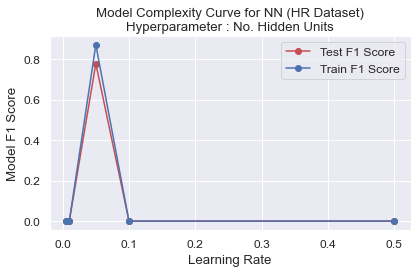

Per Hyperparameter tuning, best parameters are:
{'activation': 'relu', 'hidden_layer_sizes': 8, 'learning_rate_init': 0.01}


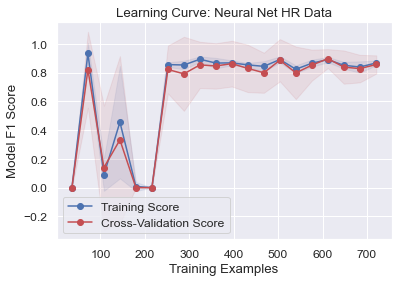

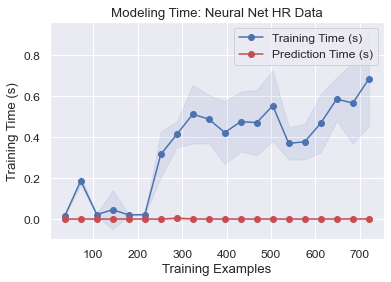

Test - Unseen Data Confusion Matrix


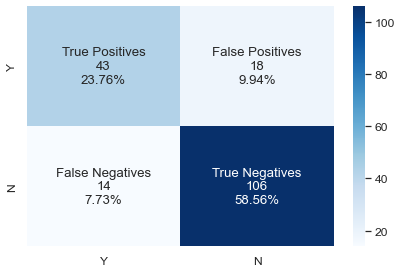

Test - Unseen Data Classification Report


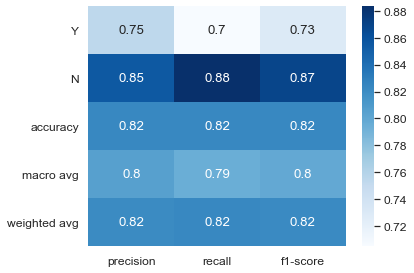

In [254]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (HR Dataset)\nHyperparameter : No. Hidden Units")
h_units, learn_rate, f_activation = NNGridSearchCV(X_train, y_train)
estimator_hr = MLPClassifier(hidden_layer_sizes=h_units, solver='adam', activation=f_activation, 
                               learning_rate_init=learn_rate, random_state=1)
train_samp_hr, NN_train_score_hr, NN_fit_time_hr, NN_pred_time_hr = plot_learning_curve(estimator_hr, X_train, y_train,title="Neural Net HR Data")
final_classifier_evaluation(estimator_hr, X_train, X_test, y_train, y_test ,'Test - Unseen Data')


<div class="alert alert-block alert-warning">
<b>5.3 Boosting Decision Tree</b>
</div> </a><a class="anchor" id="encoding"></a>

In [266]:
from sklearn.ensemble import GradientBoostingClassifier

def hyperBoost(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), 
                                             min_samples_leaf=int(min_samples_leaf/2), random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),
                  'max_depth': np.arange(3,10),
                  'n_estimators': np.linspace(10,200,3).round().astype('int'),
                  'learning_rate': [0.01,0.05,0.1,0.5]}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=5)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['max_depth'], boost.best_params_['min_samples_leaf'], boost.best_params_['n_estimators'], boost.best_params_['learning_rate']


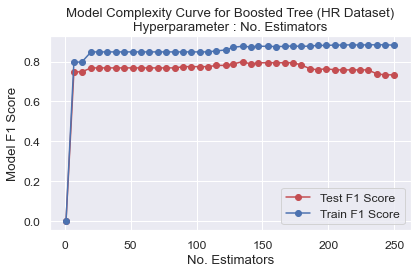

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 4, 'n_estimators': 200}


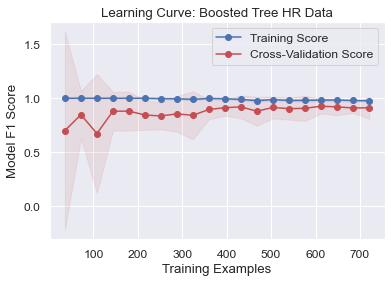

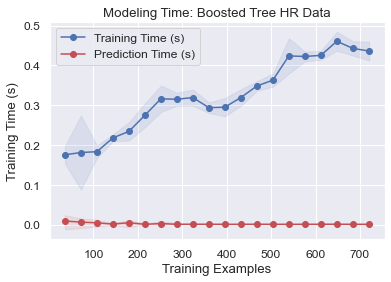

Test - Unseen Data Confusion Matrix


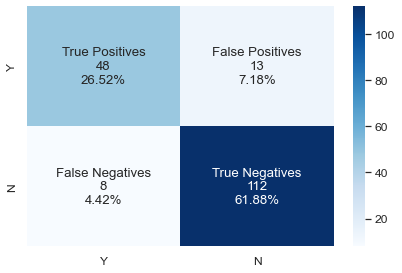

Test - Unseen Data Classification Report


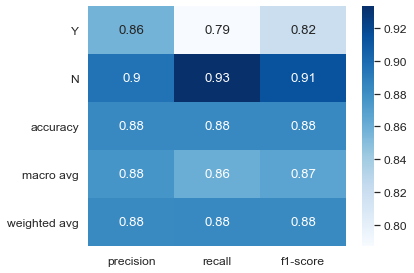

In [267]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)


hyperBoost(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (HR Dataset)\nHyperparameter : No. Estimators")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) 
max_depth, min_samples_leaf, n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_hr = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                              n_estimators=n_est, learning_rate=learn_rate, random_state=100)
train_samp_hr, BT_train_score_hr, BT_fit_time_hr, BT_pred_time_hr = plot_learning_curve(estimator_hr, X_train, y_train,title="Boosted Tree HR Data")
final_classifier_evaluation(estimator_hr, X_train, X_test, y_train, y_test ,'Test - Unseen Data')


<div class="alert alert-block alert-warning">
<b>5.4 Support Vector Machine</b>
</div> </a><a class="anchor" id="encoding"></a>

In [257]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','rbf']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    Cs = [1,0.1]
    kernels = ['linear','poly','rbf']
    param_grid = {'C': Cs,  'kernel': kernels}

    clf = GridSearchCV(estimator = SVC(random_state=100),
                       param_grid=param_grid, cv=5)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['kernel']

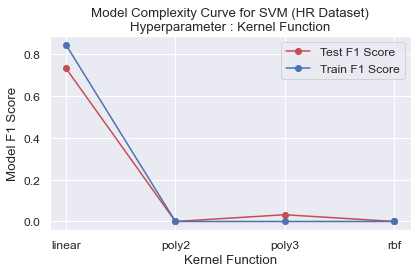

Per Hyperparameter tuning, best parameters are:
{'C': 1, 'kernel': 'linear'}


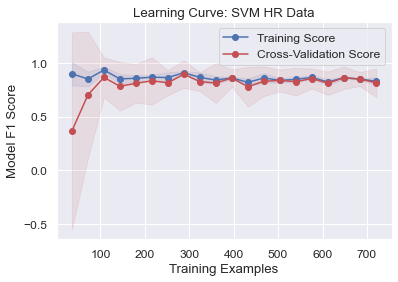

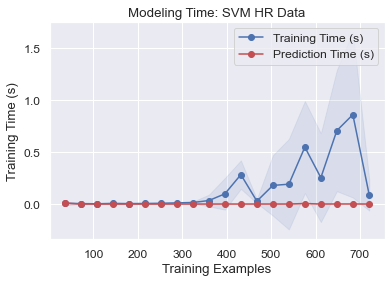

Test - Unseen Data Confusion Matrix


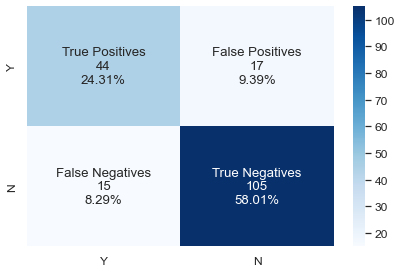

Test - Unseen Data Classification Report


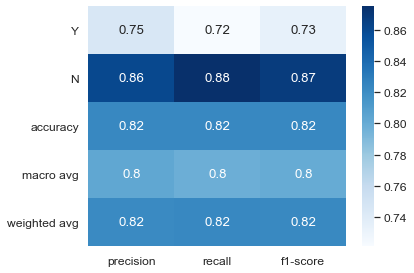

Wall time: 11.7 s


In [258]:
%%time

X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (HR Dataset)\nHyperparameter : Kernel Function")

C_val, kernel_val = SVMGridSearchCV(X_train, y_train)

estimator_hr = SVC(C=C_val, kernel=kernel_val, random_state=100)
train_samp_hr, SVM_train_score_hr, SVM_fit_time_hr, SVM_pred_time_hr = plot_learning_curve(estimator_hr, X_train, y_train,title="SVM HR Data")
final_classifier_evaluation(estimator_hr, X_train, X_test, y_train, y_test,'Test - Unseen Data')

##### <div class="alert alert-block alert-warning">
<b>5.5 K-nearest neighbors</b>
</div> </a><a class="anchor" id="encoding"></a>

In [259]:
from sklearn.neighbors import KNeighborsClassifier as kNN

def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

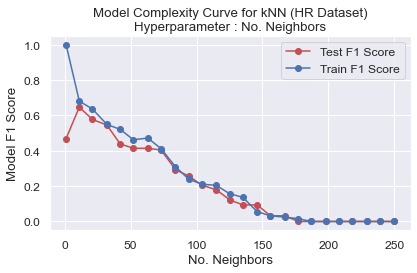

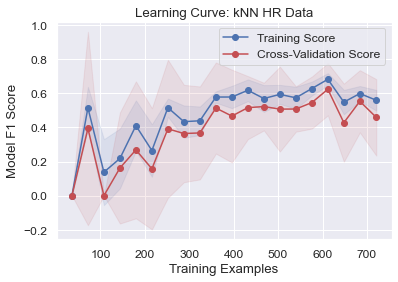

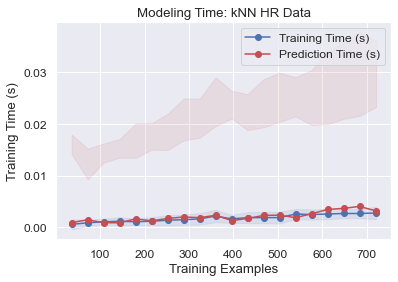

Test - Unseen Data Confusion Matrix


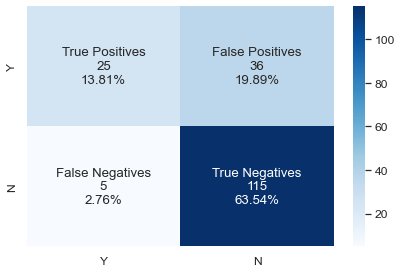

Test - Unseen Data Classification Report


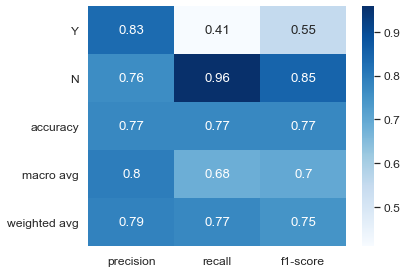

In [260]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperKNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (HR Dataset)\nHyperparameter : No. Neighbors")
estimator_hr = kNN(n_neighbors=20, n_jobs=-1)
train_samp_hr, kNN_train_score_hr, kNN_fit_time_hr, kNN_pred_time_hr = plot_learning_curve(estimator_hr, X_train, y_train,title="kNN HR Data")
final_classifier_evaluation(estimator_hr, X_train, X_test, y_train, y_test,'Test - Unseen Data')

<div class="alert alert-block alert-warning">
<b>5.6 Compare and contrast the different algorithms</b>
</div> </a><a class="anchor" id="encoding"></a>

In [261]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, SMVlearn, '-', color="r", label="SVM")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show() 

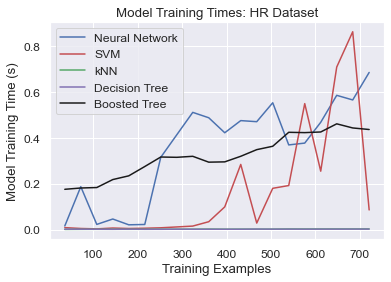

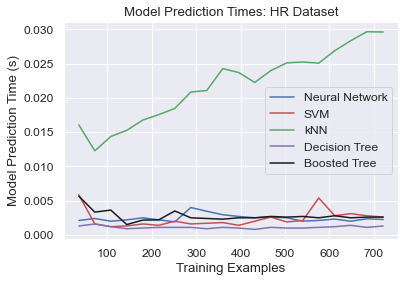

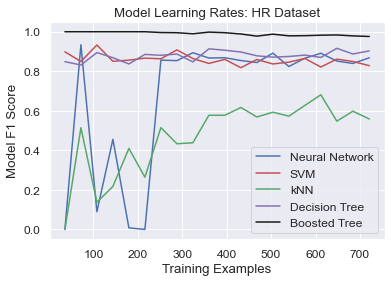

In [268]:
compare_fit_time(train_samp_hr, NN_fit_time_hr, SVM_fit_time_hr, kNN_fit_time_hr, 
                 DT_fit_time_hr, BT_fit_time_hr, 'HR Dataset')              
compare_pred_time(train_samp_hr, NN_pred_time_hr, SVM_pred_time_hr, kNN_pred_time_hr, 
                 DT_pred_time_hr, BT_pred_time_hr, 'HR Dataset')   
compare_learn_time(train_samp_hr, NN_train_score_hr, SVM_train_score_hr, kNN_train_score_hr, 
                 DT_train_score_hr, BT_train_score_hr, 'HR Dataset')  
